<a href="https://colab.research.google.com/github/IvanVoinovGitHub/Covid19-Analysis-Modeling/blob/main/PAModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID PA Forecast: SIR model + ML regressions

The emergence of the coronavirus disease (COVID-19), which is an infectious disease caused by the SARS-CoV-2 virus, has devastated economies and caused unprecedented challenges to healthcare and food systems around the world. Globally, billions of people have been ordered to stay at home as a result of lockdowns and social distancing measures being put in place. Many will agree that the pandemic has significantly affected how the general population connects to and interacts with others. This loss of connection has been further impaired by the inability to meet with others at central areas of social interaction and support such as restaurants, libraries, sports facilities and both cultural and community centers. In efforts to tackle this pandemic, it is imperative that a model is created to accurately predict the spread of COVID-19. Thus, our research emphasizes creating a model that will accurately predict the spread of COVID-19 using machine learning methods.



**TABLE OF CONTENTS**

1. [Loading in PA data](#section1)

    
    
2. [SIR model](#section2)

    2.1. [Implementing the SIR model](#section21)
    
    2.2. [Fit SIR parameters to real data](#section22)
    
3. [Data enrichment](#section3)

    3.1. [Join data, filter dates and clean missings](#section31)
    
    3.2. [Compute lags and trends](#section32)
    
    3.3. [Add country details](#section33)
    
4. [Predictions for the early stages of the transmission](#section4)

    4.1. [Linear Regression for one country](#section41)
    
    4.2. [Linear Regression for all countries (method 1)](#section42)
    
    4.3. [Linear Regression for all countries (method 2)](#section43)
    
    4.4. [Linear regression with lags](#section44)
    
5. [Predictions for the late stages of the transmission](#section5)

    5.1. [Logistic curve fit](#section51)
    
    5.2. [Logistic curve fit for all countries](#section52)
    
    5.3. [ARIMA](#section53)
    
6. [Statement of the author](#section6)

**Disclaimer 1**: this notebook is being updated frequently with the objective of improving predictions by using new models.

**Disclaimer 2**: the training dataset is also updated on a daily basis in order to include the most recent cases. In order to be up to date and prevent data leaking and other potential problems, daily updates on "filtered dates" will be applied.

**Disclaimer 3**: the COVID Global Forecasting competition is updated week by week (with a new competition). I'll move the notebook from previous weeks to the new one, so that it only appears in the most recent competition. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import subprocess
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# 1. Loading in PA Data <a id="section1"></a>

In this section the PA data is loaded in and combined to create a dataset that we will use for predicting covid cases.


In [2]:
#COVID-19 Aggregate Cases Current Daily County Health
url1 = "https://data.pa.gov/api/views/j72v-r42c/rows.csv?accessType=DOWNLOAD"
data1 = pd.read_csv(url1)

#Data Cleaning 
data11 = data1.drop(["Latitude", "Georeferenced Lat & Long", "Longitude"], axis = 1)
data11.rename(columns = {'County FIPS Code':'FIPS'}, inplace = True)
data11 = data11.rename(columns = {data11.columns[4] : 'Cum_cases'})
data11 = data11.dropna()
data11['Date'] = pd.to_datetime(data11['Date'])
data11['Date'] = data11['Date'].dt.strftime('%m/%d/%Y')
data11['Date'] = pd.to_datetime(data11['Date'])

#print(data11.info())
data11.head(10)


,Jurisdiction,Date,New Cases,7-day Average New Cases,Cum_cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,FIPS
0,Mifflin,2021-03-26,9,9.0,4787,46138,19.5,19.5,10375.4,42087
1,Juniata,2021-09-29,14,13.4,2661,24763,56.5,54.2,10745.9,42067
2,Warren,2022-01-13,70,43.0,6158,39191,178.6,109.7,15712.8,42123
3,Columbia,2022-02-18,21,23.0,14750,64964,32.3,35.4,22704.9,42037
4,Columbia,2022-01-17,89,116.7,12813,64964,137.0,179.7,19723.2,42037
5,Elk,2021-12-07,15,15.0,4948,29910,50.2,50.2,16543.0,42047
6,Juniata,2021-05-04,3,3.3,2096,24763,12.1,13.3,8464.2,42067
7,Elk,2021-02-02,6,10.7,2168,29910,20.1,35.8,7248.4,42047
8,Juniata,2021-09-17,10,9.7,2500,24763,40.4,39.2,10095.7,42067
9,Warren,2021-11-21,3,35.6,4822,39191,7.7,90.8,12303.8,42123


In [3]:
#United States COVID-19 County Level of Community Transmission as Originally Posted
url2 = "https://data.cdc.gov/api/views/8396-v7yb/rows.csv?accessType=DOWNLOAD"
data2 = pd.read_csv(url2)

#Data Cleaning
data22 = data2.query('state_name == "Pennsylvania"')
data22 = data22.drop(["cases_per_100K_7_day_count_change", "state_name", "county_name"], axis = 1)
data22.rename(columns = {'fips_code':'FIPS', 'report_date': 'Date'}, inplace = True)
data22 = data22.dropna()
data22['Date'] = pd.to_datetime(data22['Date'])
data22['Date'] = data22['Date'].dt.strftime('%m/%d/%Y')
data22['Date'] = pd.to_datetime(data22['Date'])

#Change the transmission levels
data22 = data22.replace(['low'], 0)
data22 = data22.replace(['moderate'], 1)
data22 = data22.replace(['substantial'], 2)
data22 = data22.replace(['high'], 3)

#data22['community_transmission_level'] = data22['community_transmission_level'].replace(['low','moderate', 'substantial', 'high'], [0,1,2,3])

#print(data22.info())
data22.head(10)

,FIPS,Date,percent_test_results_reported_positive_last_7_days,community_transmission_level
6,42039,2021-08-16,7.88,2
11,42025,2021-08-16,4.95,3
45,42035,2021-08-19,11.72,3
88,42085,2021-08-23,8.57,3
129,42017,2021-08-26,6.41,3
133,42117,2021-08-26,8.59,2
145,42099,2021-08-27,14.56,3
173,42071,2021-08-29,10.43,3
286,42013,2021-09-07,7.46,3
297,42089,2021-09-07,13.63,3


In [4]:
#COVID-19 Vaccinations in the United States,Jurisdiction
url3 = "https://data.cdc.gov/api/views/unsk-b7fc/rows.csv?accessType=DOWNLOAD"
data3 = pd.read_csv(url3)

#Data Cleaning 
data33 = data3.query('Location == "PA"')
data33 = data33.drop(["MMWR_week", "Distributed_Janssen", "Distributed_Moderna", "Distributed_Pfizer", "Distributed_Unk_Manuf", "Dist_Per_100K", "Distributed_Per_100k_12Plus", "Distributed_Per_100k_18Plus", "Distributed_Per_100k_65Plus", "Administered_12Plus", "Administered_18Plus", "Administered_65Plus", "Administered_Janssen", "Administered_Moderna", "Administered_Pfizer", "Administered_Unk_Manuf", "Admin_Per_100K", "Admin_Per_100k_12Plus", "Admin_Per_100k_18Plus", "Admin_Per_100k_65Plus", "Recip_Administered", "Administered_Dose1_Recip_12Plus", "Administered_Dose1_Recip_12PlusPop_Pct", "Administered_Dose1_Recip_18Plus", "Administered_Dose1_Recip_18PlusPop_Pct", "Administered_Dose1_Recip_65Plus", "Administered_Dose1_Recip_65PlusPop_Pct", "Series_Complete_12Plus", "Series_Complete_12PlusPop_Pct", "Series_Complete_18Plus", "Series_Complete_18PlusPop_Pct", "Series_Complete_65Plus", "Series_Complete_65PlusPop_Pct", "Series_Complete_Janssen", "Series_Complete_Moderna", "Series_Complete_Pfizer", "Series_Complete_Unk_Manuf", "Series_Complete_Janssen_12Plus", "Series_Complete_Moderna_12Plus", "Series_Complete_Pfizer_12Plus", "Series_Complete_Unk_Manuf_12Plus", "Series_Complete_Janssen_18Plus", "Series_Complete_Moderna_18Plus", "Series_Complete_Pfizer_18Plus", "Series_Complete_Unk_Manuf_18Plus", "Series_Complete_Janssen_65Plus", "Series_Complete_Moderna_65Plus", "Series_Complete_Pfizer_65Plus", "Series_Complete_Unk_Manuf_65Plus", "Additional_Doses_12Plus", "Additional_Doses_12Plus_Vax_Pct", "Additional_Doses_18Plus", "Additional_Doses_18Plus_Vax_Pct", "Additional_Doses_50Plus", "Additional_Doses_50Plus_Vax_Pct", "Additional_Doses_65Plus", "Additional_Doses_65Plus_Vax_Pct", "Additional_Doses_Moderna", "Additional_Doses_Pfizer", "Additional_Doses_Janssen", "Additional_Doses_Unk_Manuf", "Administered_Dose1_Recip_5Plus", "Administered_Dose1_Recip_5PlusPop_Pct", "Series_Complete_5Plus", "Series_Complete_5PlusPop_Pct", "Administered_5Plus", "Admin_Per_100k_5Plus", "Series_Complete_Moderna_5Plus", "Series_Complete_Pfizer_5Plus", "Series_Complete_Janssen_5Plus", "Series_Complete_Unk_Manuf_5Plus"], axis =1)
data33['Date'] = pd.to_datetime(data33['Date'])
data33['Date'] = data33['Date'].dt.strftime('%m/%d/%Y')
data33['Date'] = pd.to_datetime(data33['Date'])
data33 = data33.drop('Location', axis =1)

#print(data33.info())
data33.head(10)

,Date,Distributed,Administered,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Series_Complete_Yes,Series_Complete_Pop_Pct,Additional_Doses,Additional_Doses_Vax_Pct,Distributed_Per_100k_5Plus
35,2022-04-14,30012325,22539547,10810234,84.4,8704752,68.0,3677186.0,42.2,247952.0
67,2022-04-13,29939625,22528100,10806953,84.4,8701030,68.0,3673627.0,42.2,247352.0
131,2022-04-12,29905425,22495403,10797793,84.3,8694354,67.9,3664492.0,42.1,247069.0
221,2022-04-11,29882325,22487636,10795308,84.3,8691454,67.9,3662170.0,42.1,246878.0
315,2022-04-10,29882325,22482965,10793827,84.3,8689783,67.9,3660680.0,42.1,246878.0
383,2022-04-09,29795825,22472518,10790873,84.3,8686408,67.9,3657197.0,42.1,246164.0
394,2022-04-08,29795825,22457550,10785831,84.3,8682027,67.8,3652318.0,42.1,246164.0
452,2022-04-07,29708725,22446301,10782644,84.2,8678318,67.8,3648557.0,42.0,245444.0
512,2022-04-06,29665125,22431687,10778370,84.2,8673652,67.8,3644256.0,42.0,245084.0
623,2022-04-05,29619525,22414957,10773907,84.2,8669022,67.7,3639624.0,42.0,244707.0


In [40]:
#Merging all of the tables
final_data1 = pd.merge(left = data11, right = data22, how = 'outer', on = ['FIPS', 'Date'])
final_data1 = final_data1.sort_values(by='Jurisdiction') 
final_data1 = final_data1.dropna()
final_data = pd.merge(left = final_data1, right = data33, how = 'outer', on = 'Date')
final_data = final_data.dropna()
final_data = final_data.drop("Distributed_Per_100k_5Plus", axis = 1)
final_data.sort_values(by=['Jurisdiction', 'Date'])
final_data = final_data.drop(["Jurisdiction", "FIPS"], axis = 1)

#Group by Date 
final_data = final_data.groupby('Date').agg({
    'New Cases' : 'sum',
    '7-day Average New Cases' : 'sum',
    'Cum_cases' : 'sum',
    'Population (2019)' : 'sum',
    'New Case Rate' : 'sum',
    '7-Day Average New Case Rate' : 'sum',
    'Cumulative Case Rate' : 'sum',
    'percent_test_results_reported_positive_last_7_days' : 'mean',
    'community_transmission_level' : 'max',
    'Distributed' : 'mean',
    'Administered' : 'mean',
    'Administered_Dose1_Recip' : 'mean',
    'Administered_Dose1_Pop_Pct' : 'mean',
    'Series_Complete_Yes' : 'mean',
    'Series_Complete_Pop_Pct' : 'mean',
    'Additional_Doses' : 'mean',
    'Additional_Doses_Vax_Pct' : 'mean'
})

#print(final_data.info())
final_data.tail(10)

,New Cases,7-day Average New Cases,Cum_cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,percent_test_results_reported_positive_last_7_days,community_transmission_level,Distributed,Administered,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Series_Complete_Yes,Series_Complete_Pop_Pct,Additional_Doses,Additional_Doses_Vax_Pct
Date,,,,,,,,,,,,,,,,,
2022-04-03,450.0,632.2,2783806.0,12801989.0,141.1,288.9,1510023.2,2.729552,3.0,29582725.0,22381132.0,10763593.0,84.1,8657937.0,67.6,3628486.0,41.9
2022-04-06,1193.0,774.4,2786720.0,12801989.0,558.9,349.0,1511390.7,2.806269,3.0,29665125.0,22431687.0,10778370.0,84.2,8673652.0,67.8,3644256.0,42.0
2022-04-07,1119.0,802.4,2787839.0,12801989.0,414.7,352.6,1511805.1,2.784776,3.0,29708725.0,22446301.0,10782644.0,84.2,8678318.0,67.8,3648557.0,42.0
2022-04-08,1073.0,843.1,2788912.0,12801989.0,430.2,357.4,1512234.6,3.014925,3.0,29795825.0,22457550.0,10785831.0,84.3,8682027.0,67.8,3652318.0,42.1
2022-04-09,590.0,877.7,2789502.0,12801989.0,219.2,367.5,1512453.7,3.269403,3.0,29795825.0,22472518.0,10790873.0,84.3,8686408.0,67.9,3657197.0,42.1
2022-04-10,614.0,900.9,2790116.0,12801989.0,272.7,386.2,1512726.4,3.422090,3.0,29882325.0,22482965.0,10793827.0,84.3,8689783.0,67.9,3660680.0,42.1
2022-04-11,1013.0,938.3,2791129.0,12801989.0,501.8,404.4,1513228.1,3.493134,3.0,29882325.0,22487636.0,10795308.0,84.3,8691454.0,67.9,3662170.0,42.1
2022-04-12,1416.0,1002.3,2792545.0,12801989.0,551.5,421.6,1513779.4,3.613582,3.0,29905425.0,22495403.0,10797793.0,84.3,8694354.0,67.9,3664492.0,42.1
2022-04-13,1814.0,1091.2,2794359.0,12801989.0,677.2,438.2,1514456.8,3.641343,3.0,29939625.0,22528100.0,10806953.0,84.4,8701030.0,68.0,3673627.0,42.2


In [12]:
#Export Dataset to csv
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/My Drive/DS 440 Capstone/FINAL MODEL/PA Data/PA_Modeldata.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  final_data.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
#Splitting the data into test and train

GithubUrl = "https://github.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/raw/main/Model_Data/PA_Modeldata.csv"
data = pd.read_csv(GithubUrl)

training_data = data.sample(frac=0.8, random_state=25)
testing_data = data.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")
print("Dates go from", min(training_data['Date']), "to day", max(training_data['Date']), ", a total of", training_data['Date'].nunique(), "days of observed Covid data")

No. of training examples: 176
No. of testing examples: 44
Dates go from 2021-08-23 to day 2022-04-13 , a total of 176 days of observed Covid data


In [37]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220 entries, 2021-08-23 to 2022-04-14
Data columns (total 17 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   New Cases                                           220 non-null    float64
 1   7-day Average New Cases                             220 non-null    float64
 2   Cum_cases                                           220 non-null    float64
 3   Population (2019)                                   220 non-null    float64
 4   New Case Rate                                       220 non-null    float64
 5   7-Day Average New Case Rate                         220 non-null    float64
 6   Cumulative Case Rate                                220 non-null    float64
 7   percent_test_results_reported_positive_last_7_days  220 non-null    float64
 8   community_transmission_level                        220 non-n

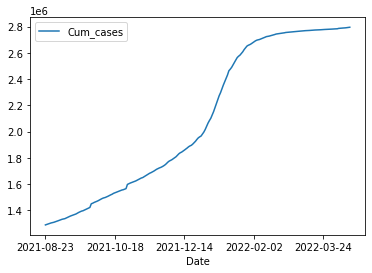

In [26]:
import matplotlib.pyplot as plt
>>> data.plot(x="Date", y=["Cum_cases"])
>>> plt.show()

# 2. SIR model <a id="section2"></a>

We have seen some general behavior of the virus in agregated data, for the country where the coronavirus was originated and for four other interesting countries. There's a lot of information to be extracted from this data; for example, we haven't analyzed the effects of long/lat of countries. However, since our main purpose is to develop a predective model in order to understand the key factors that impact the COVID-19 transmission, I'll move on to one of the most famous epidemiologic models: SIR. 

SIR is a simple model that considers a population that belongs to one of the following states:
1. **Susceptible (S)**. The individual hasn't contracted the disease, but she can be infected due to transmisison from infected people
2. **Infected (I)**. This person has contracted the disease
3. **Recovered/Deceased (R)**. The disease may lead to one of two destinies: either the person survives, hence developing inmunity to the disease, or the person is deceased. 

<img src="https://www.lewuathe.com/assets/img/posts/2020-03-11-covid-19-dynamics-with-sir-model/sir.png" width="500px">
Image by Kai Sasaki from [lewuathe.com](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html)

There are many versions of this model, considering birth and death (SIRD with demography), with intermediate states, etc. However, since we are in the early stages of the COVID-19 expansion and our interest is focused in the short term, we will consider that people develops immunity (in the long term, immunity may be lost and the COVID-19 may come back within a certain seasonality like the common flu) and there is no transition from recovered to the remaining two states. With this, the differential equations that govern the system are:

$$ {dS \over dt} = - {\beta S I \over N} $$

$$ {dI \over dt} = {\beta S I \over N} - \gamma I$$

$$ {dR \over dt} = \gamma I$$

Where $\beta$ is the contagion rate of the pathogen and $\gamma$ is the recovery rate.

## 2.1. Implementing the SIR model <a id="section21"></a>

SIR model can be implemented in many ways: from the differential equations governing the system, within a mean field approximation or running the dynamics in a social network (graph). For the sake of simplicity, I'vem chosen the first option, and we will simply run a numerical method (Runge-Kutta) to solve the differential equations system. 

The functions governing the dif.eqs. are:

In [27]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In order to solve the differential equations system, we develop a  4rth order [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) method:

In [28]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

And finally, to obtain the evolution of the disease we simply define the initial conditions and call the rk4 method:

In [29]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

Results obtained for N=world population, only one initial infected case, $\beta=0.3$, $\gamma=0.5$ and a leap pass $h_s = 0.1$ are shown below:

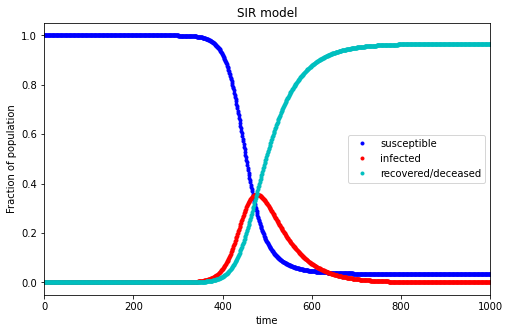

In [30]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

**Observations**: 
* The number of infected cases increases for a certain time period, and then eventually decreases given that individuals recover/decease from the disease
* The susceptible fraction of population decreases as the virus is transmited, to eventually drop to the absorbent state 0
* The oposite happens for the recovered/deceased case

Notice that different initial conditions and parameter values will lead to other scenarios, feel free to play with these numbers to study the system.

## 2.2. Fit SIR parameters to real data <a id="section22"></a>

The SIR model is purely theoretical, and we are interested into a real approximation of the COVID-19 expansion in order to extract insights and understand the transmission of the virus. Hence, we need to extract the $\beta$ and $\gamma$ paramaters for each case if we hope to be able to predict the evolution of the system.

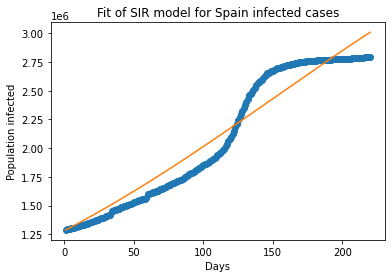

Optimal parameters: beta = 0.009175795656106472  and gamma =  0.0033098926678261933


In [42]:
population = float(12801989)
cases = data['Cum_cases']
data['day_count'] = list(range(1,len(data)+1))


ydata = [i for i in data.Cum_cases]
xdata = data.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for PA infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

**I'm not happy with the fit of parameters** and I want to work more on this, since I'm not properly reproducing the curves. I'll keep working on this for curiosity, but in the meanwhile I'll develop a data-centric approach to the prediction.

> Indented block

> Indented block





## 3.2. Compute lags and trends <a id="section32"></a>

Enriching a dataset is key to obtain good results. In this case we will apply 2 different transformations:

**Lag**. Lags are a way to compute the previous value of a column, so that the lag 1 for ConfirmedCases would inform the this column from the previous day. The lag 3 of a feature X is simply:
$$X_{lag3}(t) = X(t-3)$$


**Trend**. Transformig a column into its trend gives the natural tendency of this column, which is different from the raw value. The definition of trend I will apply is: 
$$Trend_{X} = {X(t) - X(t-1) \over X(t-1)}$$

The backlog of lags I'll apply is 14 days, while for trends is 7 days.  For ConfirmedCases and Fatalities:

In [ ]:
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0)
    return df

def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df.groupby(['Country_Region', 'Province_State'])[column].shift(0, fill_value=0) - 
                                df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0))/df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0.001)
    return df


ts = time.time()
all_data = calculate_lag(all_data.reset_index(), range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  3.167354106903076


As you see, the process is really fast. An example of some of the lag/trend columns for Spain:

In [ ]:
all_data[all_data['Country_Region']=='Spain'].iloc[40:50][['Id', 'Province_State', 'Country_Region', 'Date',
       'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num', 'ConfirmedCases_1',
       'ConfirmedCases_2', 'ConfirmedCases_3', 'Fatalities_1', 'Fatalities_2',
       'Fatalities_3']]

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,Fatalities_1,Fatalities_2,Fatalities_3
22462,25571.0,None,Spain,2020-03-02,120.0,0.0,-1.0,40,84.0,45.0,32.0,0.0,0.0,0.0
22463,25572.0,None,Spain,2020-03-03,165.0,1.0,-1.0,41,120.0,84.0,45.0,0.0,0.0,0.0
22464,25573.0,None,Spain,2020-03-04,222.0,2.0,-1.0,42,165.0,120.0,84.0,1.0,0.0,0.0
22465,25574.0,None,Spain,2020-03-05,259.0,3.0,-1.0,43,222.0,165.0,120.0,2.0,1.0,0.0
22466,25575.0,None,Spain,2020-03-06,400.0,5.0,-1.0,44,259.0,222.0,165.0,3.0,2.0,1.0
22467,25576.0,None,Spain,2020-03-07,500.0,10.0,-1.0,45,400.0,259.0,222.0,5.0,3.0,2.0
22468,25577.0,None,Spain,2020-03-08,673.0,17.0,-1.0,46,500.0,400.0,259.0,10.0,5.0,3.0
22469,25578.0,None,Spain,2020-03-09,1073.0,28.0,-1.0,47,673.0,500.0,400.0,17.0,10.0,5.0
22470,25579.0,None,Spain,2020-03-10,1695.0,35.0,-1.0,48,1073.0,673.0,500.0,28.0,17.0,10.0
22471,25580.0,None,Spain,2020-03-11,2277.0,54.0,-1.0,49,1695.0,1073.0,673.0,35.0,28.0,17.0


# 4. Predictions for the early stages of the transmission <a id="section4"></a>

Our obective in this section consists on  predicting the evolution of the expansion from a data-centric perspective, like any other regression problem. To do so, remember that the challenge specifies that submissions on the public LB shouldn only contain data previous to 2020-03-26.

Models to apply:
1. Linear Regression for one country
2. Linear Regression for all countries (method 1)
3. Linear Regression for all countries (method 2)

## 4.1. Linear Regression for one country <a id="section41"></a>

Since we are interested into predicting the future time evolution of the pandemic, our first approach consists on a simple Linear Regression. However, remind that **the evolution is** not linear but **exponential** (only in the beginning of the infection), so that a preliminar log transformation is needed. 

Visual comparison of both cases for Spain and with data from last 10 days informed, starting on March 1st:

Text(0, 0.5, 'Log ConfirmedCases')

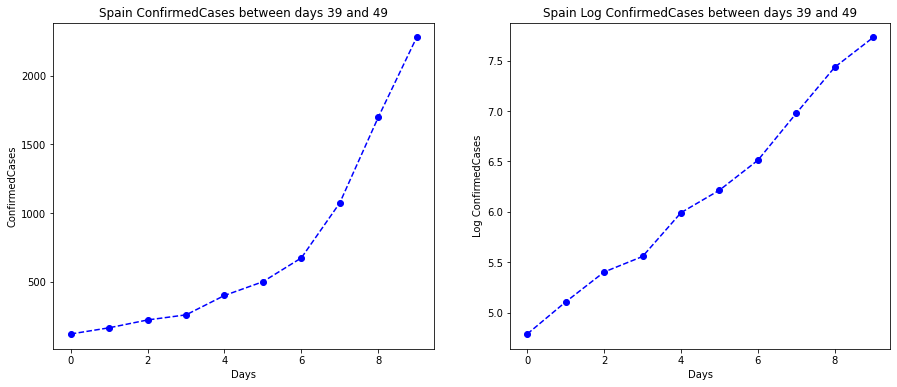

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Day_num = 38 is March 1st
y1 = all_data[(all_data['Country_Region']==country_dict['Spain']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("Spain ConfirmedCases between days 39 and 49")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

y2 = all_data[(all_data['Country_Region']==country_dict['Spain']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("Spain Log ConfirmedCases between days 39 and 49")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log ConfirmedCases")

As you see, the log transformation results in a fancy straight-like line, which is awesome for Linear Regression. However, let me clarify two important points:

* This "roughly **exponential behavior**" **is only true for the initial infection stages of the pandemic** (the initial increasing of infections on the SIR model), but that's exactly the point where most countries are at the moment.

* Why do I only extract the last 10 days of data? For three reasons:
    1. In order to capture exactly the very short term component of the evolution
    2. To prevent the effects of certain variables that have been impacting the transmition speed (quarantine vs free circulation)
    3. To prevent differences on criteria when confirming cases (remember that weird slope on the China plot?)

This first model is very simple, and only elemental features will be considered: Country/Region, date information, Long and Lat. Lags. Engineered columns like lags, trends and country details are not introduced as an input. Finally, the workflow for the Basic Linear Regression model is:
1. **Features**. Select features
2. **Dates**. Filter train data from 2020-03-01 to 2020-03-18
2. **Log transformation**. Apply log transformation to ConfirmedCases and Fatalities
3. **Infinites**. Replace infinites from the logarithm with 0. Given the asymptotic behavior of the logarithm for log(0),this implies that when applying the inverse transformation (exponential) a 1 will be returned instead of a 0. This problem does not impact many countries, but still needs to be tackled sooner or later in order to obtain a clean solution.
4. **Train/test split**. Split into train/valid/test
5. **Prediction**. Linear Regression, training country by country and joining data
6. **Submit**. Submit results in the correct format, and applying exponential to reverse log transformation 

In [ ]:
# Filter selected features
data = all_data.copy()
features = ['Id', 'ForecastId', 'Country_Region', 'Province_State', 'ConfirmedCases', 'Fatalities', 
       'Day_num']
data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log1p(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


# Split data into train/test
def split_data(df, train_lim, test_lim):
    
    df.loc[df['Day_num']<=train_lim , 'ForecastId'] = -1
    df = df[df['Day_num']<=test_lim]
    
    # Train set
    x_train = df[df.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = df[df.ForecastId == -1]['ConfirmedCases']
    y_train_2 = df[df.ForecastId == -1]['Fatalities']

    # Test set
    x_test = df[df.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


# Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred


# Submission function
def get_submission(df, target1, target2):
    
    prediction_1 = df[target1]
    prediction_2 = df[target2]

    # Submit predictions
    prediction_1 = [int(item) for item in list(map(round, prediction_1))]
    prediction_2 = [int(item) for item in list(map(round, prediction_2))]
    
    submission = pd.DataFrame({
        "ForecastId": df['ForecastId'].astype('int32'), 
        "ConfirmedCases": prediction_1, 
        "Fatalities": prediction_2
    })
    submission.to_csv('submission.csv', index=False)

Let's try to see results when training with a single country:

* **Spain**

In [ ]:
# Select train (real) data from March 1 to last day updated
dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', 
                 '2020-03-10', '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', 
                 '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', 
                 '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14']

In [ ]:
all_data.loc[all_data['Country_Region']==country_dict['Spain']][50:70]

,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,...,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
22472,25580,25581.0,83,156,2020-03-12,2277.0,55.0,-1.0,50,12,...,0.571429,0.964286,2.235294,4.500000,10.000000,46750879.0,94.0,498800.0,45.0,80.0
22473,25581,25582.0,83,156,2020-03-13,5232.0,133.0,-1.0,51,13,...,1.462963,2.800000,3.750000,6.823529,12.300000,46750879.0,94.0,498800.0,45.0,80.0
22474,25582,25583.0,83,156,2020-03-14,6391.0,195.0,-1.0,52,14,...,2.545455,2.611111,4.571429,5.964286,10.470588,46750879.0,94.0,498800.0,45.0,80.0
22475,25583,25584.0,83,156,2020-03-15,7798.0,289.0,-1.0,53,15,...,1.172932,4.254545,4.351852,7.257143,9.321429,46750879.0,94.0,498800.0,45.0,80.0
22476,25584,25585.0,83,156,2020-03-16,9942.0,342.0,-1.0,54,16,...,0.753846,1.571429,5.218182,5.333333,8.771429,46750879.0,94.0,498800.0,45.0,80.0
22477,25585,25586.0,83,156,2020-03-17,11748.0,533.0,-1.0,55,17,...,0.844291,1.733333,3.007519,8.690909,8.870370,46750879.0,94.0,498800.0,45.0,80.0
22478,25586,25587.0,83,156,2020-03-18,13910.0,623.0,-1.0,56,18,...,0.821637,1.155709,2.194872,3.684211,10.327273,46750879.0,94.0,498800.0,45.0,80.0
22479,25587,25588.0,83,156,2020-03-19,17963.0,830.0,-1.0,57,19,...,0.557223,1.426901,1.871972,3.256410,5.240602,46750879.0,94.0,498800.0,45.0,80.0
22480,25588,25589.0,83,156,2020-03-20,20410.0,1043.0,-1.0,58,20,...,0.674157,0.956848,2.049708,2.608997,4.348718,46750879.0,94.0,498800.0,45.0,80.0
22481,25589,25590.0,83,156,2020-03-21,25374.0,1375.0,-1.0,59,21,...,0.656627,1.207063,1.579737,3.020468,3.757785,46750879.0,94.0,498800.0,45.0,80.0


ValueError: ignored

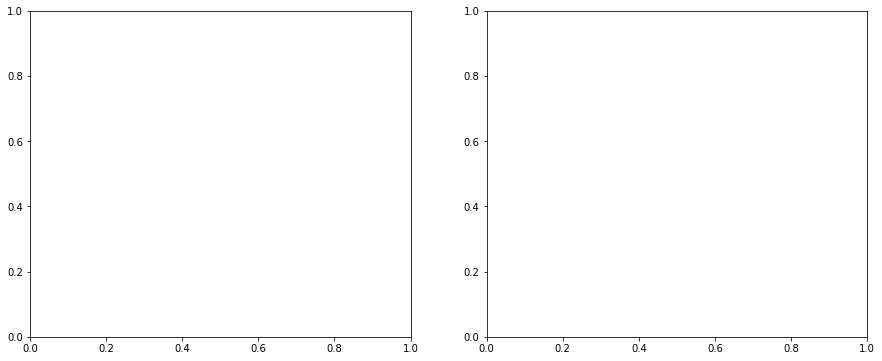

In [ ]:
def plot_linreg_basic_country(data, country_name, dates_list, day_start, shift, train_lim, test_lim):
    
    data_country = data[data['Country_Region']==country_dict[country_name]]
    data_country = data_country.loc[data_country['Day_num']>=day_start]
    X_train, Y_train_1, Y_train_2, X_test = split_data(data_country, train_lim, test_lim)
    model, pred = lin_reg(X_train, Y_train_1, X_test)

    # Create a df with both real cases and predictions (predictions starting on March 12th)
    X_train_check = X_train.copy()
    X_train_check['Target'] = Y_train_1

    X_test_check = X_test.copy()
    X_test_check['Target'] = pred

    X_final_check = pd.concat([X_train_check, X_test_check])

    # Select predictions from March 1st to March 25th
    predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(30-shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (from March " + str(1+shift) + " to March 25th)")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(30-shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (from March " + str(1+shift) + " to March 30th)")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))
    
    
    
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
train_lim, test_lim = 69, 112
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

In [ ]:
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

* **Italy**

In [ ]:
# Filter Italy, run the Linear Regression workflow
country_name = "Italy"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

In [ ]:
# Filter Italy, run the Linear Regression workflow
country_name = "Italy"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

* **Germany**

In [ ]:
# Filter Germany, run the Linear Regression workflow
country_name = "Germany"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

In [ ]:
# Filter Germany, run the Linear Regression workflow
country_name = "Germany"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

* **Albania**

In [ ]:
# Filter Albania, run the Linear Regression workflow
country_name = "Albania"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

In [ ]:
# Filter Albania, run the Linear Regression workflow
country_name = "Albania"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

* **Andorra**

In [ ]:
# Filter Andorra, run the Linear Regression workflow
country_name = "Andorra"
shift = 10
day_start = 39+shift
dates_list2 = dates_list[shift:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, shift, train_lim, test_lim)

In [ ]:
# Filter Andorra, run the Linear Regression workflow
country_name = "Andorra"
shift = 21
day_start = 39+shift
dates_list2 = dates_list[shift:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, shift, train_lim, test_lim)

**Observations**:

* The general evolution is captured despite the simplicity of the model
* The cumulative infected cases has been changing in March, so that using thw whole month data for training results in overestimated predictions. When reducing the training set to only a few days prior the testing region, results are better. This is capturing the problem of the exponential behavior, that is only true for the early stages of the spreading. Now the behavior is more complex, and in order to predict the evolution with large portions of the historic evolution, alternative models are required (sigmoid, ARIMA...)
* Estimations are increasingly worse as time passes (harder to extrapolate)
* Countries that recently confirmed their first contagions are difficult to predict (less data points) 
* Countries with 0 cases in the whole training dataset are predicted as non-infected (no datapoints)

** Questions to tackle in next subsections**:
* How to obtain the full submission set? 
* What to do for countries with different Provinces/State informed?
* Is there any alternative to manually setting the size of the train data? 

## 4.2 Linear Regression for all countries (method 1) <a id="section42"></a>

We've recently discovered that when fitting only with 10 historical datapoints some problematic scenarios appear, that impact the performance of our Linear Regressor. Let's generalize the model for all countries to verify if it's an unavoidable problem. Steps to run for all countries:

1. Loop for each country
2. Compute provinces list
3. If there are provinces, run the Linear Regressor for each of them
4. Otherwise just run the Linear Regressor

In [ ]:
ts = time.time()

def linreg_basic_all_countries(data, day_start, train_lim, test_lim):
    
    data2 = data.loc[data.Day_num >= day_start]

    # Set the dataframe where we will update the predictions
    data_pred = data[data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
    data_pred = data_pred.loc[data_pred['Day_num']>=day_start]
    data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
    data_pred['Predicted_Fatalities'] = [0]*len(data_pred)

    print("Currently running Linear Regression for all countries")

    # Main loop for countries
    for c in data2['Country_Region'].unique():

        # List of provinces
        provinces_list = data2[data2['Country_Region']==c]['Province_State'].unique()

        # If the country has several Province/State informed
        if len(provinces_list)>1:
            for p in provinces_list:
                data_cp = data2[(data2['Country_Region']==c) & (data2['Province_State']==p)]
                X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp, train_lim, test_lim)
                model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
                model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
                data_pred.loc[((data_pred['Country_Region']==c) & (data2['Province_State']==p)), 'Predicted_ConfirmedCases'] = pred_1
                data_pred.loc[((data_pred['Country_Region']==c) & (data2['Province_State']==p)), 'Predicted_Fatalities'] = pred_2

        # No Province/State informed
        else:
            data_c = data2[(data2['Country_Region']==c)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_c, train_lim, test_lim)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred.loc[(data_pred['Country_Region']==c), 'Predicted_ConfirmedCases'] = pred_1
            data_pred.loc[(data_pred['Country_Region']==c), 'Predicted_Fatalities'] = pred_2

    # Apply exponential transf. and clean potential infinites due to final numerical precision
    data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.expm1(x))
    data_pred.replace([np.inf, -np.inf], 0, inplace=True) 
    
    return data_pred


day_start = 65
#data_pred = linreg_basic_all_countries(data, day_start, train_lim, test_lim)
#get_submission(data_pred, 'Predicted_ConfirmedCases', 'Predicted_Fatalities')

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Final [LMSE score](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a) for week 2, with training data prior to 2020-03-19 and measures on date 2020-04-01: 

**1.19681**

## 4.3 Linear Regression for all countries (method 2) <a id="section43"></a>

An alternative method to setting the number of days for the training step is to simply keep all data for each country since the first case was confirmed. However, since there are certain countries were the initial outbreak was very smooth (i.e. in Spain there was only one confirmed case for 7 days in a row), predictions may be biased by these initial periods.

In [ ]:
ts = time.time()

# Set the dataframe where we will update the predictions
day_start = 65
data2 = data.loc[data.Day_num >= day_start]
data_pred3 = data2[data2.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
data_pred3['Predicted_ConfirmedCases'] = [0]*len(data_pred3)
data_pred3['Predicted_Fatalities'] = [0]*len(data_pred3)
how_many_days = test.Date.nunique()
    
print("Currently running Linear Regression for all countries")

# Main loop for countries
for c in data['Country_Region'].unique():
    
    # List of provinces
    provinces_list = data2[data2['Country_Region']==c]['Province_State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        
        for p in provinces_list:
            # Only fit starting from the first confirmed case in the country
            train_countries_no0 = data.loc[(data['Country_Region']==c) & (data['Province_State']==p) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
            test_countries_no0 = data.loc[(data['Country_Region']==c) & (data['Province_State']==p) &  (data.ForecastId!=-1)]
            data2 = pd.concat([train_countries_no0, test_countries_no0])

            # If there are no previous cases, predict 0
            if len(train_countries_no0) == 0:
                data_pred3.loc[((data_pred2['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
                data_pred3.loc[((data_pred2['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_Fatalities'] = [0]*how_many_days
                
            # Else run LinReg
            else: 
                data_cp = data2[(data2['Country_Region']==c) & (data2['Province_State']==p)]
                X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp, train_lim, test_lim)
                model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
                model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
                data_pred3.loc[((data_pred3['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_ConfirmedCases'] = pred_1
                data_pred3.loc[((data_pred3['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_Fatalities'] = pred_2

    # No Province/State informed
    else:
        # Only fit starting from the first confirmed case in the country
        train_countries_no0 = data.loc[(data['Country_Region']==c) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
        test_countries_no0 = data.loc[(data['Country_Region']==c) &  (data.ForecastId!=-1)]
        data2 = pd.concat([train_countries_no0, test_countries_no0])

        # If there are no previous cases, predict 0
        if len(train_countries_no0) == 0:
            data_pred3.loc[((data_pred3['Country_Region']==c)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
            data_pred3.loc[((data_pred3['Country_Region']==c)), 'Predicted_Fatalities'] = [0]*how_many_days
        
        # Else, run LinReg
        else:
            data_c = data2[(data2['Country_Region']==c)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_c, train_lim, test_lim)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred3.loc[(data_pred3['Country_Region']==c), 'Predicted_ConfirmedCases'] = pred_1
            data_pred3.loc[(data_pred3['Country_Region']==c), 'Predicted_Fatalities'] = pred_2

# Aplly exponential transf. and clean potential infinites due to final numerical precision
#data_pred3[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred3[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.expm1(x))
#data_pred3.replace([np.inf, -np.inf], 0, inplace=True) 

#get_submission(data_pred3, 'Predicted_ConfirmedCases', 'Predicted_Fatalities')

print("Process finished in ", round(time.time() - ts, 2), " seconds")

From my experiments, this apporach is not suitable for our linear regression model. In many cases there are strong transitional periods at the beginning, which frequently biases the regression. Hence, I will not apply this method on following sections, but you are welcome to use it for any other purposes.

Final [LMSE score](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a) for week 2, with training data prior to 2020-03-19 and measures on date 2020-04-01: 

**1.62190**

## 4.4. Linear regression with lags <a id="section44"></a>

With all the previous results in mind, I quite believe that Linear Regression is a good approach for the early stages of the COVID-19 spread. Of course, this is only true for the initial outbreak we are analysing, and there's no way our model could predict when the number of new infections is going to decrease. But for short-term prediction purposes everything is fine, and we are in disposition to try to improve the results.

Remember those lagged variables we computed some sections before? Now it's time to use them, but first there's a problem to solve. If we use our dataset to predict the next following days of contagions, for the first day all the lags will be reported (from the previous days), but what about the next days? **Many of the lags will be unknown** (flagged as 0), since the number of ConfirmedCases is only known for the train subset. The most simple approach to overcome this is:

1. Begin with the train dataset, with all cases and lags reported
2. Forecast only the following day, through the Linear Regression
3. Set the new prediction as a confirmed case
4. Recompute lags
5. Repeat from step 2 to step 4 for all remaining days

As usual, I'll start training on single countries in order to analyze the behavior of the model with these new features.

In [ ]:
# New split function, for one forecast day
def split_data_one_day(df, d, train_lim, test_lim):
    
    df.loc[df['Day_num']<=train_lim , 'ForecastId'] = -1
    df = df[df['Day_num']<=test_lim]
    
    #Train
    x_train = df[df.Day_num<d]
    y_train_1 = x_train.ConfirmedCases
    y_train_2 = x_train.Fatalities
    x_train.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    #Test
    x_test = df[df.Day_num==d]
    x_test.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


def plot_real_vs_prediction_country(data, train, country_name, day_start, dates_list, march_day):

    # Select predictions from March 1st to March 25th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].ConfirmedCases
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(30-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March " + str(march_day) + "))")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(30-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))
    
    
def plot_real_vs_prediction_country_fatalities(data, train, country_name, day_start, dates_list, march_day):

    # Select predictions from March 1st to March 25th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Fatalities
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['Fatalities']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(30-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax1.set_ylabel("Fatalities Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(30-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax2.set_ylabel("Log Fatalities Cases")

    plt.suptitle(("Fatalities predictions based on Log-Lineal Regression for "+country_name))

* **Spain**

In [ ]:
# Function to compute the Linear Regression predictions with lags, for a certain Country/Region
def lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province_State', 'Country_Region',
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[data['Country_Region']==country_dict[country_name]]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,8), 'Fatalities')

    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    
    # Apply log transformation
    data[filter_col] = data[filter_col].apply(lambda x: np.log1p(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)


    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d, train_lim, test_lim)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,8), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    #print("Process for ", country_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data


# Function to compute the Linear Regression predictions with lags, for a certain Country/Region and State/province
def lin_reg_with_lags_country_province(all_data, country_name, province_name, day_start, lag_size, country_dict, train_lim, test_lim):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province_State', 'Country_Region',
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name])]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,lag_size), 'Fatalities')

    # Apply log transformation
    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    data[filter_col] = data[filter_col].apply(lambda x: np.log1p(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)

    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d, train_lim, test_lim)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name])
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,lag_size), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    #print("Process for ", country_name, "/", province_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data



# Run the model for Spain
country_name = 'Spain'
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Italy**

In [ ]:
ts = time.time()

# Inputs
country_name = "Italy"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Germany**

In [ ]:
# Inputs
country_name = "Germany"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Albania**

In [ ]:
# Inputs
country_name = "Albania"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 7

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Andorra**

In [ ]:
# Inputs
country_name = "Andorra"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 1

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

**Observations**:
* **Parameters**. Two full weeks of training used (from February 26th to March 11th), with their previous 30 lags
* **Enough data**. (Spain, Italy, Germany). For countries with several ConfirmedCases!=0 in the train dataset (prior to March 11th), predictions are very precise and similar to actual confirmed data
* **Poor data**. (Algeria, Andorra). Countries with a small number of datapoints in the train dataset show a potentially disastrous prediction. Given the small number of cases, the log transformation followed by a Linear Regression is not able to capture the future behavior
* **No data**. When the number of confirmed cases in the train dataset is 0 or negligible, the model predicts always no infections

Let's generalize the model with lags for training each country day by day:

In [ ]:
"""
# Inputs
day_start = 39 
lag_size = 30

train3 = train.copy()
train3.Province_State.fillna("None", inplace=True)

results_df = pd.DataFrame()

tp = time.time()

# Main loop for countries
for country_name in train3['Country_Region'].unique():

    # List of provinces
    provinces_list = train3[train3['Country_Region']==country_name]['Province_State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        for province_name in provinces_list:
            pred_province = lin_reg_with_lags_country_province(all_data, country_name, province_name, day_start, lag_size, country_dict, train_lim, test_lim)
            results_df = pd.concat([results_df, pred_province])

    else:
        pred_country = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
        results_df = pd.concat([results_df, pred_country])
        
results_df_submit = results_df.copy()
results_df_submit['ConfirmedCases'] = results_df_submit['ConfirmedCases'].apply(lambda x: np.expm1(x))
results_df_submit['Fatalities'] = results_df_submit['Fatalities'].apply(lambda x: np.expm1(x))
        
#get_submission(results_df_submit.loc[results_df_submit['ForecastId']!=-1], 'ConfirmedCases', 'Fatalities')
print("Complete process finished in ", time.time()-tp)
"""

Nice, extending the model for all countries and days has been quite easy, but a tricky part needs to be addressed. As we saw when analyzing the results for certain countries, some of them have too few training datapoints different from 0, and these scenarios sometimes end up with the regression algorithm predicting absurd values.  

For the sake of simplicity, my proposal to overcome this problem consists on mixing the current results with those from [section 4.2.](#section42), where we trained the model for all countries without lags. All countries with too few confirmed cases in the training dataset will be predicted with results from section 4.2.

In [ ]:
"""
results_df_2 = results_df.copy()

day_start = 39
data_pred2 = linreg_basic_all_countries(data, day_start, train_lim, test_lim)
day_num_test = 57    # Day 2020-04-18


# Main loop for countries
for country_name in train3['Country_Region'].unique():

    # List of provinces
    provinces_list = train3[train3['Country_Region']==country_name]['Province_State'].unique()

    # Countries with several Province_State informed
    if len(provinces_list)>1:
        for province_name in provinces_list:
        
            tmp_index = all_data.index[(all_data['Country_Region']==country_dict[country_name]) & 
                           (all_data['Province_State']==province_dict[province_name]) & 
                           (all_data['Day_num']<day_num_test) & 
                           (all_data['ConfirmedCases']!=0)]

            # When there is not enough data
            if len(tmp_index) < 30:
                
                # ConfirmedCases
                results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                                  (results_df_2['Province_State']==province_dict[province_name]) &
                                  (results_df_2['Day_num']>=day_num_test)), 'ConfirmedCases'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                                  (data_pred2['Province_State']==province_dict[province_name]) & 
                                  (data_pred2['Day_num']>=day_num_test)), 'Predicted_ConfirmedCases'].apply(lambda x: np.log1p(x))
                
                #Fatalities
                results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                                  (results_df_2['Province_State']==province_dict[province_name]) &
                                  (results_df_2['Day_num']>=day_num_test)), 'Fatalities'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                                  (data_pred2['Province_State']==province_dict[province_name]) & 
                                  (data_pred2['Day_num']>=day_num_test)), 'Predicted_Fatalities'].apply(lambda x: np.log1p(x))
                
    # Countries without Province_State
    else:
        tmp_index = all_data.index[(all_data['Country_Region']==country_dict[country_name]) & 
                           (all_data['Day_num']<day_num_test) & 
                           (all_data['ConfirmedCases']!=0)]

        # When there is not enough data
        if len(tmp_index) < 30:
            
            #Confirmed Cases
            results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                            (results_df_2['Day_num']>=day_num_test)), 'ConfirmedCases'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                            (data_pred2['Day_num']>=day_num_test)), 'Predicted_ConfirmedCases'].apply(lambda x: np.log1p(x))
            
            results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                            (results_df_2['Day_num']>=day_num_test)), 'Fatalities'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                            (data_pred2['Day_num']>=day_num_test)), 'Predicted_Fatalities'].apply(lambda x: np.log1p(x))
            
results_df_2 = results_df_2.loc[results_df_2['Day_num']>=day_num_test]
#results_df_2[['ConfirmedCases', 'Fatalities']] = results_df_2[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.expm1(x))
#get_submission(results_df_2, 'ConfirmedCases', 'Fatalities')
"""

# 5. Predictions for the late stages of the transmission (under construction)<a id="section5"></a>

As the transmission progresses, **the exponential regime is left behind** and the Linear Regressor we developed begins to predict worse results. We were aware of this limitation, and now **alternative methods are required** in order to capture the new behavior.

I'd like to clarify that the aim of this section will be to predict the immediate future evolution of the number of cases, not to estimate when the peack of infections will happen or to which extent the COVID-19 will spread in each country. 

Models considered in this section:

1. Logistic curve fit

2. Logistic curve fit for all countries

3. ARIMA


## 5.1. Logistic curve fit <a id="section51"></a>

In [ ]:
def logistic_function(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

def fit_logistic(all_data, country_name, province_name, train_lim, target):
    data_cp = all_data.loc[(all_data['Country_Region']==country_dict[country_name]) & (all_data['Province_State']==province_dict[province_name])]
    y = data_cp.loc[(data_cp['Day_num'])<=train_lim, target].astype(np.int32)
    x = list(range(0, len(y)))

    # Initial guess
    p0 = [0,1,1,0]

    (a_, b_, c_, d_), cov = optimize.curve_fit(logistic_function, x, y, bounds=(0, [500000., 10., 1000., 1000., ]), p0=p0, maxfev=10**9)
    y_fit = logistic_function(x, a_, b_, c_, d_)
    
    return x, y, y_fit, (a_, b_, c_, d_), cov

def plot_logistic(x, y, y_fit, country_name, province_name, target):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(x, y, 'o')
    ax.plot(x, y_fit, '-')
    ax.set_xlabel("Day count (starting on January 22nd)")
    ax.set_ylabel(target)
    ax.set_title("Fit to logistic regression for "+ country_name+"/"+province_name)
    

def plot_logistic_country(all_data, train, dates_overlap, country_name, province_name, valid_num, target, x, a_, b_, c_, d_):
    forecast = logistic_function(list(range(len(x)+60)), a_, b_, c_, d_)
    df_train = train.loc[(train['Country_Region']==country_name) & (train['Province_State']==province_name), target]
    df_fcst = forecast[:len(df_train)]
    dates = list(range(0,len(df_train)))
    
    # Plot results
    fig, (ax1) = plt.subplots(1, 1, figsize=(6,4))
    ax1.plot(dates, df_fcst)
    ax1.plot(dates, df_train)
    ax1.axvline(len(df_train)-valid_num-1, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.set_title("Actual ConfirmedCases vs predictions based on Logistic curve for "+country_name + "/"+province_name)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count starting on January 22nd")
    ax1.set_ylabel("ConfirmedCases")


# Fit country to logistic curve
country_name = 'Spain'
province_name = 'None'
train_lim = 69
valid_lim = 84 # needs to be changed as more days of training data are included
test_lim = 112
valid_num=valid_lim-train_lim 

x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')
plot_logistic_country(all_data, train, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)

* **Italy**

In [ ]:
# Fit country to logistic curve
country_name = 'Italy'
province_name = 'None'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')
plot_logistic_country(all_data, train, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)

* **Germany**

In [ ]:
# Fit country to logistic curve
country_name = 'Germany'
province_name = 'None'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')
plot_logistic_country(all_data, train, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)

* **Albania**

In [ ]:
# Fit country to logistic curve
country_name = 'Albania'
province_name = 'None'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')
plot_logistic_country(all_data, train, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)

* **Andorra**

In [ ]:
# Fit country to logistic curve
country_name = 'Andorra'
province_name = 'None'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')
plot_logistic_country(all_data, train, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)

*** China/Hubei**

In [ ]:
# Fit country to logistic curve
country_name = 'China'
province_name = 'Hubei'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
plot_logistic(x, y, y_fit, country_name, province_name, 'ConfirmedCases')
plot_logistic_country(all_data, train, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases', x, a_, b_, c_, d_)

## 5.2. Logistic curve fit for all countries <a id="section52"></a>

In [ ]:
train_lim = 69
test_lim = 112

def logistic_forecast_allcountries(all_data, train, train_lim, test_lim):
    
    ts = time.time()
    data_pred = all_data[all_data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
    data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
    data_pred['Predicted_Fatalities'] = [0]*len(data_pred)

    # Main loop for countries
    for country_name in train['Country_Region'].unique():
        for province_name in train[train['Country_Region']==country_name]['Province_State'].unique():
            
            # ConfirmedCases
            x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'ConfirmedCases')
            pred_1 = [logistic_function(t, a_, b_, c_, d_) for t in list(range(train_lim+1, test_lim+1))]
            data_pred.loc[((data_pred['Country_Region']==country_dict[country_name]) & (data_pred['Province_State']==province_dict[province_name])), 'Predicted_ConfirmedCases'] = pred_1

            # Fatalities
            x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'Fatalities')
            pred_2 = [logistic_function(t, a_, b_, c_, d_) for t in list(range(train_lim+1, test_lim+1))]
            data_pred.loc[((data_pred['Country_Region']==country_dict[country_name]) & (data_pred['Province_State']==province_dict[province_name])), 'Predicted_Fatalities'] = pred_2


    print("Logistic function fit for all countries finished in ", round(time.time() - ts, 2), " seconds")
    return data_pred
    
logistic_forecast = logistic_forecast_allcountries(all_data, train, train_lim, test_lim) 
get_submission(logistic_forecast, 'Predicted_ConfirmedCases', 'Predicted_Fatalities')

## 5.3. ARIMA <a id="section53"></a>

Autoregressive integrated moving average (ARIMA) models are mainly used for time-series analysis, since they are capable to predict the future values of a variable based only on its historical evolution. ARIMA models can be understood by dividing them in three main concepts, each of them with a related parameter:
* **AR**: the regression of the predicted variable is based on its previous values (lags). The $p$ parameter defines the number of these terms.
$$\sum_{i=1}^p \phi_i y_{t-i}$$

* **I**: data values used for the regression are differenciated until they are stationary. Instead of working with $y_t$, it uses terms of . Parameter $d$ is related to the number of differences need for stationarity.
$$y'_t \sim y_t-y_{t-1}$$

* **MA**: the error of the regression is based on a linear combination of error terms from the past (lags of errors). Parameter $q$ is the number of lagged forecast errors in the prediction equation. 
$$\sum_{i=1}^q \theta_i \epsilon_{t-i}$$

In general, the model can be written as:
$$ y_{t}' =  c + \phi_1 y'_{t-1} + ... + \phi_p y'_{t-p} + \theta_1 \epsilon_{t-1} ... + \theta_q \epsilon_{t-q} - \epsilon_t $$

In order to keep the notebook clean and don't overextend, I won't go into further details of the model. For a rich explanation of ARIMA models you can visit the [Monash University online textbook](https://otexts.com/fpp2/arima.html).

In [ ]:
!pip install pyramid.arima
from pyramid.arima import auto_arima

* **Spain**

In [ ]:
# Define a general function to run ARIMA regression
def arima_cp(all_data, country_name, province_name, target, train_lim, test_lim):
    
    #Select data for the Country/Region, splitting train/test days
    data_cp = all_data.loc[(all_data['Country_Region']==country_dict[country_name]) & (all_data['Province_State']==province_dict[province_name])]
    data_cp_train = data_cp.loc[(data_cp['Day_num'])<=train_lim, target].astype(np.int32)
    data_cp_test = data_cp.loc[(data_cp['Day_num'])>test_lim, target].astype(np.int32)

    # Set the range of parameters to use
    stepwise_model = auto_arima(data_cp[target], start_p=1, start_q=1, max_p=30, max_q=30, 
                                start_P=0, seasonal=False, d=2, trace=False, error_action='ignore', stepwise=True)

    # Train and predict
    stepwise_model.fit(data_cp_train, start_ar_lags=2*max(30, 30))
    forecast = stepwise_model.predict(n_periods=test_lim-train_lim)
    return forecast


# Plot the actual values vs predictions
def plot_arima_country(all_data, train, forecast, dates_overlap, country_name, province_name, valid_num, target):
    df_train = train.loc[(train['Country_Region']==country_name) & (train['Province_State']==province_name), target]
    df_fcst = np.append(df_train[:-valid_num], forecast[:valid_num])
    dates = list(range(0,len(df_train)))
    
    # Plot results
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,6))
    ax1.plot(dates, df_fcst)
    ax1.plot(dates, df_train)
    ax1.axvline(len(df_train)-valid_num-1, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.set_title("Actual ConfirmedCases vs predictions based on ARIMA for "+country_name + "/"+province_name)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count starting on January 22nd")
    ax1.set_ylabel("ConfirmedCases")
    
    
    
# Inputs
country_name = 'Spain'
province_name = 'None'

forecast = arima_cp(all_data, country_name, province_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases')

* **Italy**

In [ ]:
# Inputs
country_name = 'Italy'
province_name = 'None'

forecast = arima_cp(all_data, country_name, province_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases')

* **Germany**

In [ ]:
# Inputs
country_name = 'Germany'
province_name = 'None'

forecast = arima_cp(all_data, country_name, province_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases')

* **Albania**

In [ ]:
# Inputs
country_name = 'Albania'
province_name = 'None'

forecast = arima_cp(all_data, country_name, province_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases')

* **Andorra**

In [ ]:
# Inputs
country_name = 'Andorra'
province_name = 'None'

forecast = arima_cp(all_data, country_name, province_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases')

* **China/Hubei**

In [ ]:
# Inputs
country_name = 'China'
province_name = 'Hubei'

forecast = arima_cp(all_data, country_name, province_name, 'ConfirmedCases', train_lim, test_lim)
plot_arima_country(all_data, train, forecast, dates_overlap, country_name, province_name, valid_num, 'ConfirmedCases')

In [ ]:
"""
train_lim = 69
test_lim = 112

ARIMA_forecast = all_data[all_data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
ARIMA_forecast['Predicted_ConfirmedCases'] = [0]*len(ARIMA_forecast)
ARIMA_forecast['Predicted_Fatalities'] = [0]*len(ARIMA_forecast)

# Main loop for countries
for c in train['Country_Region'].unique():
        for p in train[train['Country_Region']==c]['Province_State'].unique():
            print(c, p)
            pred_1 = arima_cp(all_data, c, p, 'ConfirmedCases', train_lim, test_lim)
            #pred_2 = arima_cp(all_data, c, p, 'Fatalities', train_lim, test_lim)
            ARIMA_forecast.loc[((ARIMA_forecast['Country_Region']==country_dict[c]) & (ARIMA_forecast['Province_State']==province_dict[p])), 'Predicted_ConfirmedCases'] = pred_1
            #ARIMA_forecast.loc[((ARIMA_forecast['Country_Region']==country_dict[c]) & (ARIMA_forecast['Province_State']==province_dict[p])), 'Predicted_Fatalities'] = pred_2
            
"""

In [ ]:
""" WEIRD OVERESTIMATED CASE
# Fit country to logistic curve
country_name = 'South Africa'
province_name = 'None'
target = 'ConfirmedCases'
#target='Fatalities'
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, target)
plot_logistic(x, y, y_fit, country_name, province_name, target)

#x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, target)
pred_1 = [logistic_function(t, a_, b_, c_, d_) for t in list(range(train_lim+1, test_lim+1))]

pred_1

logistic_forecast[(logistic_forecast['Country_Region']==66) & (logistic_forecast['Province_State']==81)]
"""